In [1]:
import matplotlib.pyplot as plt
import vaex
import os
import numpy as np
import pandas as pd
from helpers import *

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from helpers import *
import pandas as pd
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'
## Parallel function to compute response function
from multiprocessing import Pool
import multiprocessing
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KernelDensity
from fastdtw import fastdtw
from scipy.stats import ttest_ind, ranksums
import time

### 1) Data Labelling
Assumption : a flash crash is defined as a price drop of more than 5% in a 30 minute window


In [16]:
# Data loading
current_dir  = os.getcwd()
loading_dir = os.path.join(current_dir,"data","clean", "flash_crash")
ticker_list = os.listdir(loading_dir)
if '.DS_Store' in ticker_list : ticker_list.remove('.DS_Store')
ticker_name =   ticker_list[1]
print("Ticker name: ", ticker_name)

plots_dir = os.path.join(current_dir,"plots","flash_crash",ticker_name)
file_dir = os.path.join(loading_dir,ticker_name)
file_name = os.listdir(file_dir)[0]
df = vaex.open(os.path.join(file_dir,file_name))

# Data cleaning 
df = df[ (df.index>= '2010-05-06') & (df.index<= '2010-05-07') ]

df = df.dropnan(column_names=["trade_price"])
df = df.to_pandas_df()
df.loc[:, ['bid-price', 'bid-volume','ask-price','ask-volume', ]] = df[['bid-price','bid-volume','ask-price','ask-volume']].ffill().fillna(method='bfill')

df["mid_price"] = (df["bid-price"] + df["ask-price"])/2
ny_index = pd.DatetimeIndex(df['index']) 
ny_index = ny_index.tz_localize('UTC').tz_convert('America/New_York')
df['ny_index'] = ny_index 
df.set_index('ny_index',drop=True,inplace=True)


# Data Labelling
## Label as flash crash where the drop and recovery exceed the thresholds within the window
WINDOW = '1800s' # 30 minutes
PRICE_DROP_THRESHOLD = 0.05  # 5% price drop

def max_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.max() - series) / series).max()

def min_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.min() - series) / series).min()

# Calculate the rolling max and min percentage change for the 'mid_price' column
df['max_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(max_pct_change, raw=True)
df['min_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(min_pct_change, raw=True)
df['flash_crash'] = ((df['min_price_pct_change'] <= -PRICE_DROP_THRESHOLD) & (df['max_price_pct_change'] >= PRICE_DROP_THRESHOLD) ).astype(int)

print(df.flash_crash.value_counts(normalize=True))
df[['max_price_pct_change','min_price_pct_change']].describe()
print("Without sampling, df is of length : ",len(df))
df_original = df.copy()

Ticker name:  AAPL.OQ-2010
flash_crash
0    0.742953
1    0.257047
Name: proportion, dtype: float64
Without sampling, df is of length :  46260


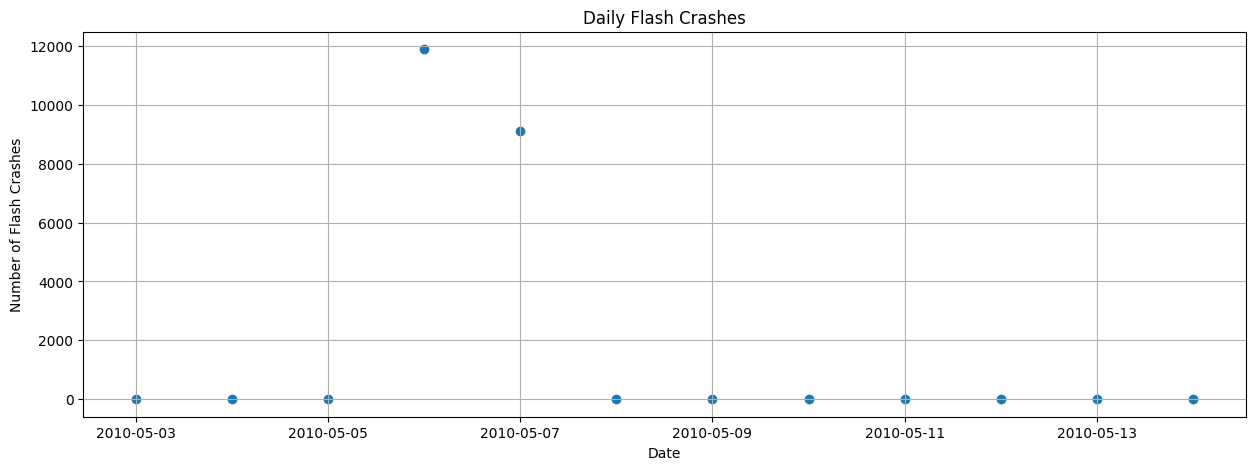

In [13]:
df_daily_crash = df.resample('1D').agg({'flash_crash': 'sum'})
df_daily_crash['date'] = df_daily_crash.index.date
plt.figure(figsize=(15, 5))
plt.scatter(df_daily_crash['date'], df_daily_crash['flash_crash'])
plt.title('Daily Flash Crashes')
plt.xlabel('Date')
plt.ylabel('Number of Flash Crashes')
plt.grid()
plt.show()

### Discussion : 
As expected, we notice that the occurences of flash crashes are very rare. In fact, with our definition of a flash crash (i.e: drop >5% within 30 minute interval), we notice only 3 months where it happened and more precisely in 4 days. After careful inspection, the first one is the famous big flash crash, the second one is on the day just after and the last two are actually just price redress at market opening.

In [17]:
## Group trades into minutes by taking sum of trade volume, mean price.. and label as flash crash if the number of trades exceed the threshold within the window
df_resampled = df.copy()
df_resampled = df_resampled.resample('1s').agg({'trade_price': 'mean', 'trade_volume': 'sum', 'ask-price': 'mean', 'bid-price': 'mean', 'ask-volume': 'sum', 'bid-volume': 'sum', 'mid_price': 'mean', 'max_price_pct_change': 'max', 'min_price_pct_change': 'min', 'flash_crash': 'max'})
df_resampled.dropna(inplace=True)
print(df_resampled.flash_crash.value_counts(normalize=True))
df_resampled[['max_price_pct_change','min_price_pct_change']].describe()
print("With sampling, df is of length : ",len(df_resampled))

flash_crash
0.0    0.832337
1.0    0.167663
Name: proportion, dtype: float64
With sampling, df is of length :  12883


#### 2) Training 
Note: Training should be done on a rolling calibration.
We cannot just perform a logistic regresssion because the flash crash actually only happens a few times so with a rolling callibration, we will mostly have one class (0: non flash crash). We can either try to label our data with a probability of crash but this needs very stong assumptions about price volatility and other metrics. Or the method we will be implementing is using the market response function. First we need a regression on a the response function, then a classification using a simple model (exceeding a magnitude threshold in values/spread)

Note: We need to use F1 score since the data is very imbalanced.

#### a) Naive approach : Use Mean squared error as loss function

In [35]:

def compute_deviation(y_pred, y_true):
    return ((y_pred - y_true)**2).mean()

# Parameters
k = 2000  # Window size
tau_max = k # should be equal to k
threshold = 0.8  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 50
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade','flash_crash'],inplace=True)

    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print('*'*50)
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    # print(f"Time taken: {end_time-start_time}")
    print(f"Deviation :     {deviation}")
    # print(f"Metrices: {metrics}")
    # print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(2* window_deviation)
    else :
        predicted_flash_crash = deviation > threshold
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

**************************************************
At time 2010-05-06 10:29:19-04:00
flash crash: predicted: False, actual : False 
Deviation :     0.012436582480474648
**************************************************
At time 2010-05-06 10:29:27-04:00
flash crash: predicted: False, actual : False 
Deviation :     0.010350847625933865
**************************************************
At time 2010-05-06 10:29:29-04:00
flash crash: predicted: False, actual : False 
Deviation :     0.008773691954150415
**************************************************
At time 2010-05-06 10:29:30-04:00
flash crash: predicted: False, actual : False 
Deviation :     0.007558753500005993
**************************************************
At time 2010-05-06 10:29:31-04:00
flash crash: predicted: False, actual : False 
Deviation :     0.007535673495365069
**************************************************
At time 2010-05-06 10:29:32-04:00
flash crash: predicted: False, actual : False 
Deviation :     0.00868

Traceback (most recent call last):
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/xc/fqhfbxxx7yb4n__mj0cc0wvc0000gn/T/ipykernel_82331/3857354925.py", line 25, in <module>
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
  File "/Users/yacine/Desktop/Flash_crash/helpers.py", line 667, in compute_response_c
    return R[:tau_max-1]
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/signal/_signaltools.py", line 669, in fftconvolve
    ret = _freq_domain_conv(in1, in2, axes, shape, calc_fast_len=True)
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/signal/_signaltools.py", line 506, in _freq_domain_conv
    sp1 = fft(in1, fshape, axes=axes)
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/fft/_backend.py", line 25, in __ua_fu

#### b) Dynamic Time Warping (DTW):
DTW is a technique for measuring the similarity between two sequences, even when they have different lengths or are temporally misaligned. So we can use this function even when window and tau max are not equal

In [32]:
def compute_deviation(y_pred, y_true):
    distance, _ = fastdtw(y_true, y_pred)
    return distance

# Parameters
k = 2000  # Window size
tau_max = k # should be equal to k
threshold = 100  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 50
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade','flash_crash'],inplace=True)

    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation : {deviation}")
    # print(f"Metrices: {metrics}")
    # print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(2* window_deviation)
    else :
        predicted_flash_crash = deviation > threshold
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

At time 2010-05-06 10:29:19-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4489870071411133
Deviation : 62.96896427414745
At time 2010-05-06 10:29:27-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4454529285430908
Deviation : 58.57173628348042
At time 2010-05-06 10:29:29-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4421062469482422
Deviation : 56.79753374351739
At time 2010-05-06 10:29:30-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4431571960449219
Deviation : 55.01203528665147
At time 2010-05-06 10:29:31-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.433912992477417
Deviation : 53.35378818814195
At time 2010-05-06 10:29:32-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4333021640777588
Deviation : 56.08694453180067
At time 2010-05-06 10:29:33-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4343721866607666
Deviation : 60.32963484850605
At time

Traceback (most recent call last):
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/xc/fqhfbxxx7yb4n__mj0cc0wvc0000gn/T/ipykernel_82331/37721660.py", line 26, in <module>
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
  File "/Users/yacine/Desktop/Flash_crash/helpers.py", line 667, in compute_response_c
    return R[:tau_max-1]
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/signal/_signaltools.py", line 669, in fftconvolve
    ret = _freq_domain_conv(in1, in2, axes, shape, calc_fast_len=True)
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/signal/_signaltools.py", line 509, in _freq_domain_conv
    ret = ifft(sp1 * sp2, fshape, axes=axes)
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/fft/_backend.py", line 25, in __

#### c) Kernel Density Estimation (KDE)

In [30]:

def compute_deviation_wasserstein(y_pred, y_true):
    # Assuming actual_response and predicted_response are your time series data
    kde_actual = KernelDensity(kernel='gaussian').fit(np.array(y_true).reshape(-1, 1))
    kde_predicted = KernelDensity(kernel='gaussian').fit(np.array(y_pred).reshape(-1, 1))
    # Evaluate the estimated density functions on a grid
    x_grid = np.linspace(min(min(y_true), min(y_pred)),
                        max(max(y_true), max(y_pred)), 1000)
    log_density_actual = kde_actual.score_samples(x_grid.reshape(-1, 1))
    log_density_predicted = kde_predicted.score_samples(x_grid.reshape(-1, 1))
    # Calculate the Wasserstein distance between the two estimated distributions
    distance = wasserstein_distance(np.exp(log_density_actual), np.exp(log_density_predicted))
    return distance

# Parameters
k = 2000  # Window size
tau_max = k # should be equal to k
threshold = 0.01  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 50
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade','flash_crash'],inplace=True)

    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation_wasserstein(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation :     {deviation}")
    # print(f"Metrices: {metrics}")
    # print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(2* window_deviation)
    else :
        predicted_flash_crash = deviation > threshold
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

At time 2010-05-06 10:29:19-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.5293517112731934
Deviation :     0.000754188675109963
At time 2010-05-06 10:29:27-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.5252563953399658
Deviation :     0.0006867562571235969
At time 2010-05-06 10:29:29-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.5321750640869141
Deviation :     0.0006067246407505521
At time 2010-05-06 10:29:30-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.5218799114227295
Deviation :     0.0005970892084689547
At time 2010-05-06 10:29:31-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.5205848217010498
Deviation :     0.0006569916326832632
At time 2010-05-06 10:29:32-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.5202438831329346
Deviation :     0.0008333471200223531
At time 2010-05-06 10:29:33-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.520045

KeyboardInterrupt: 

#### d) Analytical observations from the response function
- Magnitude of the Response Function
- Volatility of the Response Function
- Stability of the Response Function

In [18]:
def compute_deviation(y_pred, y_true , weight_ttest=0.5,  weight_stability=0.5 ):
    # Response magnitude
    t_stat, p_value_t = ttest_ind(y_pred, y_true,alternative='less')
    U_stat, p_value_u = ranksums(y_pred, y_true,alternative='less')
    # Stability of response function
    # Calculate the coefficient of variation (CV)
    cv_true = np.std(y_true) / np.mean(y_true)
    cv_pred = np.std(y_pred) / np.mean(y_pred)
    # print("cv_true",cv_true)
    # print("cv_pred",cv_pred)
    
    # Calculate individual deviations
    deviation_ttest = ((p_value_t < 0.05) and (p_value_u<0.05) )
    # print("\ndeviation_ttest",deviation_ttest)
    # deviation_volatility = (y_std-y_pred_volatility)/y_std
    # print("deviation_volatility",deviation_volatility)
    deviation_stability = (cv_true-cv_pred)/ cv_true
    # print("deviation_stability",deviation_stability)
    
    # Calculate the overall deviation
    # overall_deviation = deviation_ttest * weight_ttest + deviation_volatility*weight_volatility + deviation_stability*weight_stability
    # overall_deviation = int(deviation_ttest) * weight_ttest + deviation_stability*weight_stability
    overall_deviation = (2-p_value_t-p_value_u)/2 * weight_ttest + deviation_stability*weight_stability
    
    return overall_deviation



In [21]:
df = df_original.copy()
df = df[ (df.index>= '2010-05-06') & (df.index<= '2010-05-08') ]
df.dropna(inplace=True)
df = df.resample('1s').agg({'trade_price': 'mean', 'trade_volume': 'sum', 'ask-price': 'mean', 'bid-price': 'mean', 'ask-volume': 'sum', 'bid-volume': 'sum', 'mid_price': 'mean', 'max_price_pct_change': 'max', 'min_price_pct_change': 'min', 'flash_crash': 'max'})
df.dropna(inplace=True)
df

,trade_price,trade_volume,ask-price,bid-price,ask-volume,bid-volume,mid_price,max_price_pct_change,min_price_pct_change,flash_crash
ny_index,,,,,,,,,,
2010-05-06 09:30:01-04:00,254.142500,700.0,254.190000,253.995000,14.0,12.0,254.092500,0.000984,-0.000983,0.0
2010-05-06 09:30:02-04:00,254.676071,3303.0,254.700000,254.000000,18.0,6.0,254.350000,0.001378,-0.001376,0.0
2010-05-06 09:30:03-04:00,254.441607,6921.0,254.746429,254.067143,208.0,55.0,254.406786,0.002382,-0.002376,0.0
2010-05-06 09:30:04-04:00,254.955556,2455.0,255.000000,253.990000,101.0,15.0,254.495000,0.002382,-0.002376,0.0
2010-05-06 09:30:05-04:00,254.690000,200.0,255.000000,253.990000,33.0,5.0,254.495000,0.002382,-0.002376,0.0
...,...,...,...,...,...,...,...,...,...,...
2010-05-06 15:59:55-04:00,246.536538,2850.0,246.713077,246.441538,57.0,50.0,246.577308,0.029973,-0.029101,0.0
2010-05-06 15:59:56-04:00,246.601042,5544.0,246.836667,246.501667,48.0,28.0,246.669167,0.029973,-0.029101,0.0
2010-05-06 15:59:57-04:00,246.419611,8681.0,246.720000,246.360000,30.0,43.0,246.540000,0.029973,-0.029101,0.0


In [27]:
# Parameters
k = 2000  # Window size
tau_max = k # should be equal to k
threshold = 0.9  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 50
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade','flash_crash'],inplace=True)

    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation : {deviation}")
    # print(f"Metrices: {metrics}")
    # print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(2* window_deviation)
    else :
        predicted_flash_crash = deviation > threshold
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

At time 2010-05-06 10:29:19-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.34131598472595215
Deviation : 0.408540130240698
At time 2010-05-06 10:29:27-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.3376481533050537
Deviation : 0.4097365744848548
At time 2010-05-06 10:29:29-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.3451368808746338
Deviation : 0.4151610194008821
At time 2010-05-06 10:29:30-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.34148406982421875
Deviation : 0.4274127756537123
At time 2010-05-06 10:29:31-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.33386898040771484
Deviation : 0.45668120539905854
At time 2010-05-06 10:29:32-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.33664798736572266
Deviation : 0.49729404595464405
At time 2010-05-06 10:29:33-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.33307886123657227
Deviation : 0.7224963537

KeyboardInterrupt: 

In [112]:
f1_score(metrics), accuracy(metrics)

(0.30736768067522424, 0.9773803986424794)

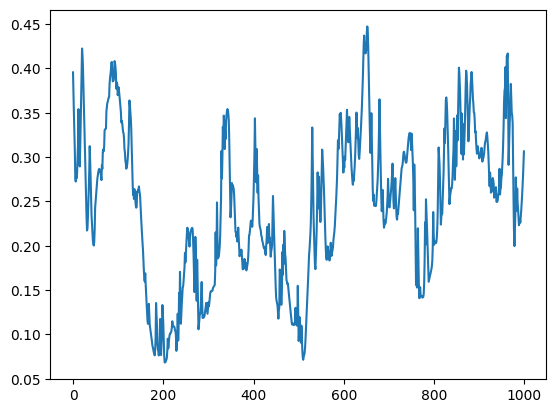

In [115]:
plt.plot(total_deviation_list[:1000])

In [116]:
metrics

{'TP': 874, 'TN': 169328, 'FP': 1072, 'FN': 2867}